In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pytorch_eo.datasets.land_cover_net import LandCoverNet
from pytorch_eo.utils.sensors import S2

ds = LandCoverNet(
    path="./data/LandCoverNet", 
    batch_size=9, 
    bands=[S2.red, S2.green, S2.blue], 
    verbose=True
)

ds.setup()

training samples 28512
validation samples 9504
test samples 9504


In [3]:
ds.classes

[{'name': 'other', 'color': '#000000'},
 {'name': 'water', 'color': '#0000ff'},
 {'name': 'artificial-bare-ground', 'color': '#888888'},
 {'name': 'natural-bare-ground', 'color': '#d1a46d'},
 {'name': 'permanent-snow-ice', 'color': '#f5f5ff'},
 {'name': 'cultivated-vegetation', 'color': '#d64c2b'},
 {'name': 'permanent-snow-and-ice', 'color': '#186818'},
 {'name': 'semi-natural-vegetation', 'color': '#00ff00'}]

In [4]:
imgs, masks = next(iter(ds.train_dataloader()))

imgs.shape, masks.shape, imgs.dtype, imgs.max(), imgs.min()

(torch.Size([9, 3, 256, 256]),
 torch.Size([9, 8, 256, 256]),
 torch.float32,
 tensor(1.),
 tensor(0.0003))

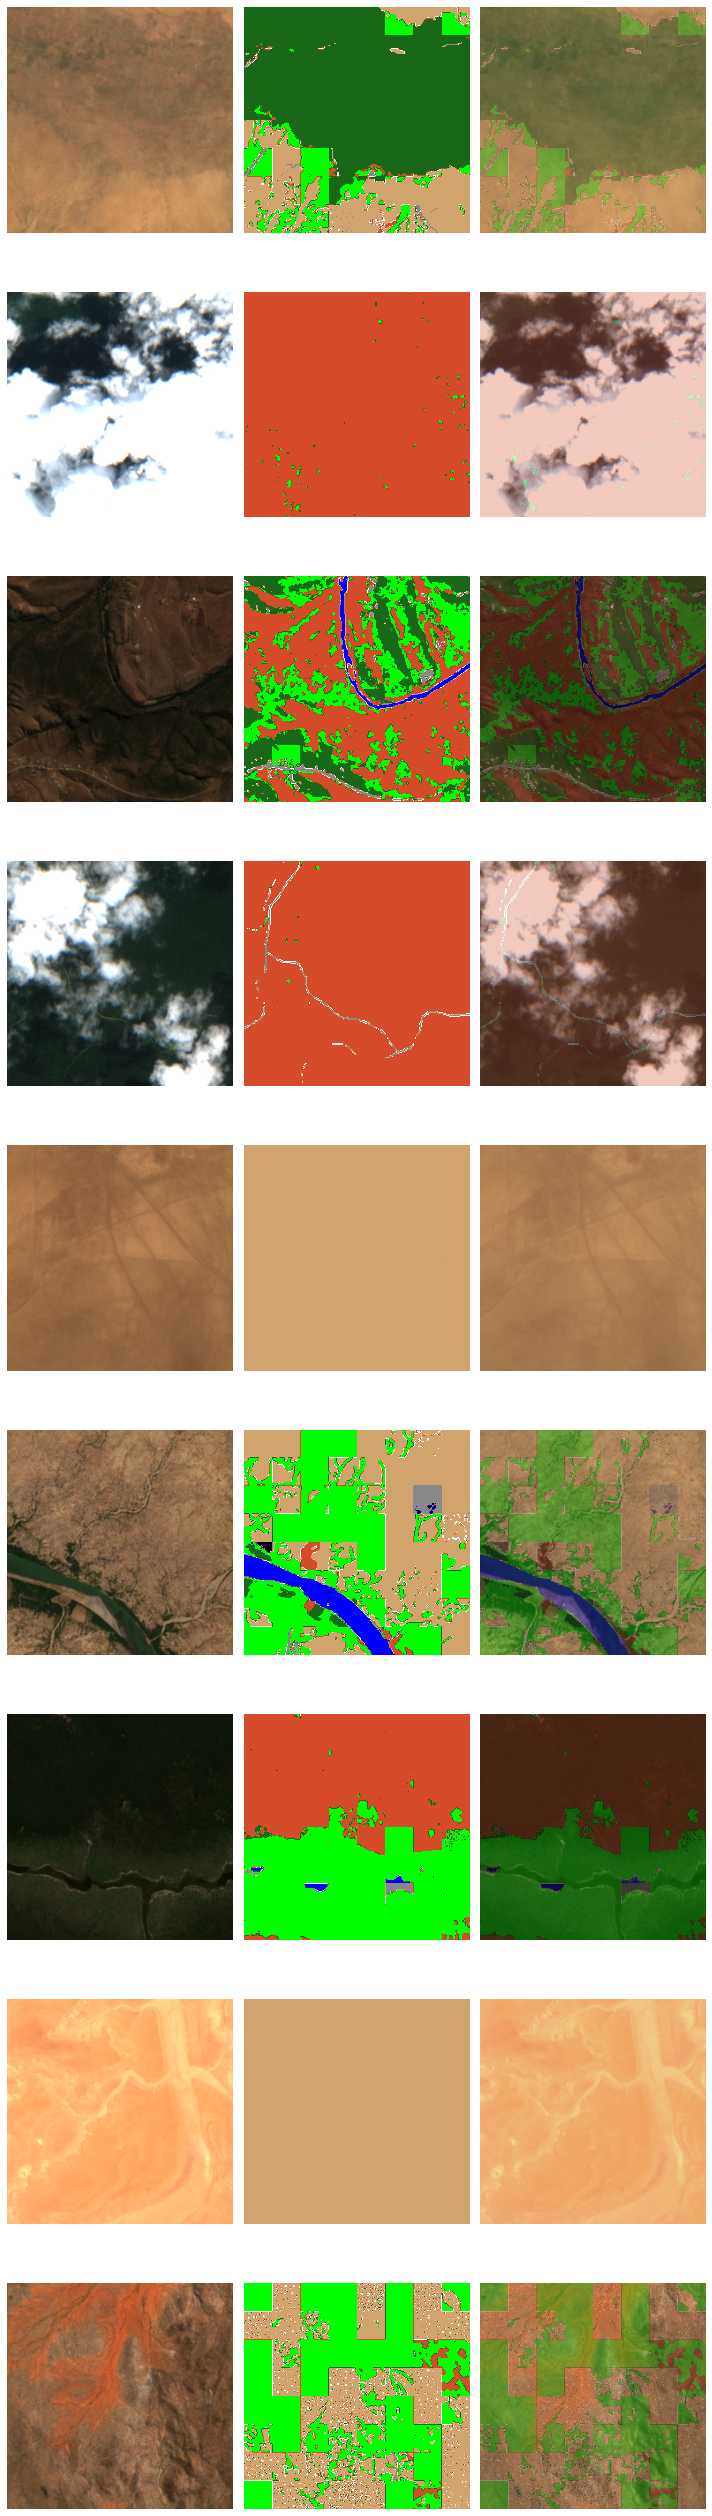

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import torch 
import numpy as np

colors = [label['color'] for label in ds.classes]
cmap = matplotlib.colors.ListedColormap(colors)
boundaries = np.arange(-0.5, len(colors) + 0.5, 1)
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N)

imgs, masks = next(iter(ds.train_dataloader()))

fig = plt.figure(figsize=(10, len(imgs)*4))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    ax = plt.subplot(len(imgs), 3, 3*i + 1)
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 2)
    mask = torch.argmax(mask, axis=0)
    ax.imshow(mask, cmap=cmap, norm=norm)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 3)
    ax.imshow(img.permute(1,2,0))
    ax.imshow(mask, cmap=cmap, norm=norm, alpha=0.3)
    #ax.imshow(mask)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from pytorch_eo.tasks.segmentation import ImageSegmentation
import segmentation_models_pytorch as smp

model = smp.Unet(
	encoder_name='resnet18',
	encoder_weights='imagenet',
	in_channels=ds.in_chans,
	classes=ds.num_classes,
)

task = ImageSegmentation(model)

out = task(imgs)

out.shape, out.dtype

(torch.Size([9, 8, 256, 256]), torch.float32)

In [7]:
from pytorch_eo.utils.datasets import SegmentationDataset
from pytorch_eo.utils.sensors import bands2names
from skimage import io
import numpy as np

class FastDataset(SegmentationDataset):
    def __init__(self, images, masks=None, trans=None, bands=None, num_classes=None, norm_value=4000):
        super().__init__(images, masks, trans, num_classes, norm_value)
        self.bands = bands2names(bands)

    def _read_image(self, img):
        bands_data = []
        for band in self.bands:
            band = io.imread(f'{img}/{band}.tif')  # H, W, uint16
            bands_data.append(torch.from_numpy(band.astype(np.float32)))
        img = torch.stack(bands_data)  # C, H, W

        # if torch.any(img.isnan()):  # there are nans in some images !
        #     img[img != img] = 0
        #     if torch.any(img.isnan()):
        #         raise ValueError('image has nans !')

        return img

    def _norm_image(self, img):
        return (img / self.norm_value).clip(0, 1)

    def _read_mask(self, mask):
        mask_np = io.imread(mask)[..., 0]  # H, W, uint16
        return torch.from_numpy(mask_np.astype(np.uint8)).long()

In [8]:
import pytorch_lightning as pl

ds = LandCoverNet(
    path="./data/LandCoverNet", 
    batch_size=128, 
    bands=[S2.red, S2.green, S2.blue],
    num_workers=20,
    pin_memory=True,
    dataset=FastDataset
)

model = smp.Unet(
	encoder_name='resnet18',
	encoder_weights='imagenet',
	in_channels=ds.in_chans,
	classes=ds.num_classes,
)

hparams = {
    'loss': 'BCEWithLogitsLoss',
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 3e-4
    }
}

task = ImageSegmentation(model, hparams)

In [9]:
trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=10,
)

trainer.fit(task, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Unet              | 14.3 M
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.317    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


In [10]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_iou': 0.6331672072410583, 'test_loss': 0.09841984510421753}
--------------------------------------------------------------------------------


[{'test_iou': 0.6331672072410583, 'test_loss': 0.09841984510421753}]

In [11]:
import torch 
from torch.utils.data import DataLoader, SubsetRandomSampler

dl = DataLoader(
    ds.ds,
    batch_size=10,
    sampler=SubsetRandomSampler(ds.test_idxs)
)

imgs, masks = next(iter(dl))

preds = task.predict(imgs)
preds = torch.argmax(preds, axis=1)

preds.shape, preds.dtype, preds.max(), preds.min()

(torch.Size([10, 256, 256]), torch.int64, tensor(7), tensor(1))

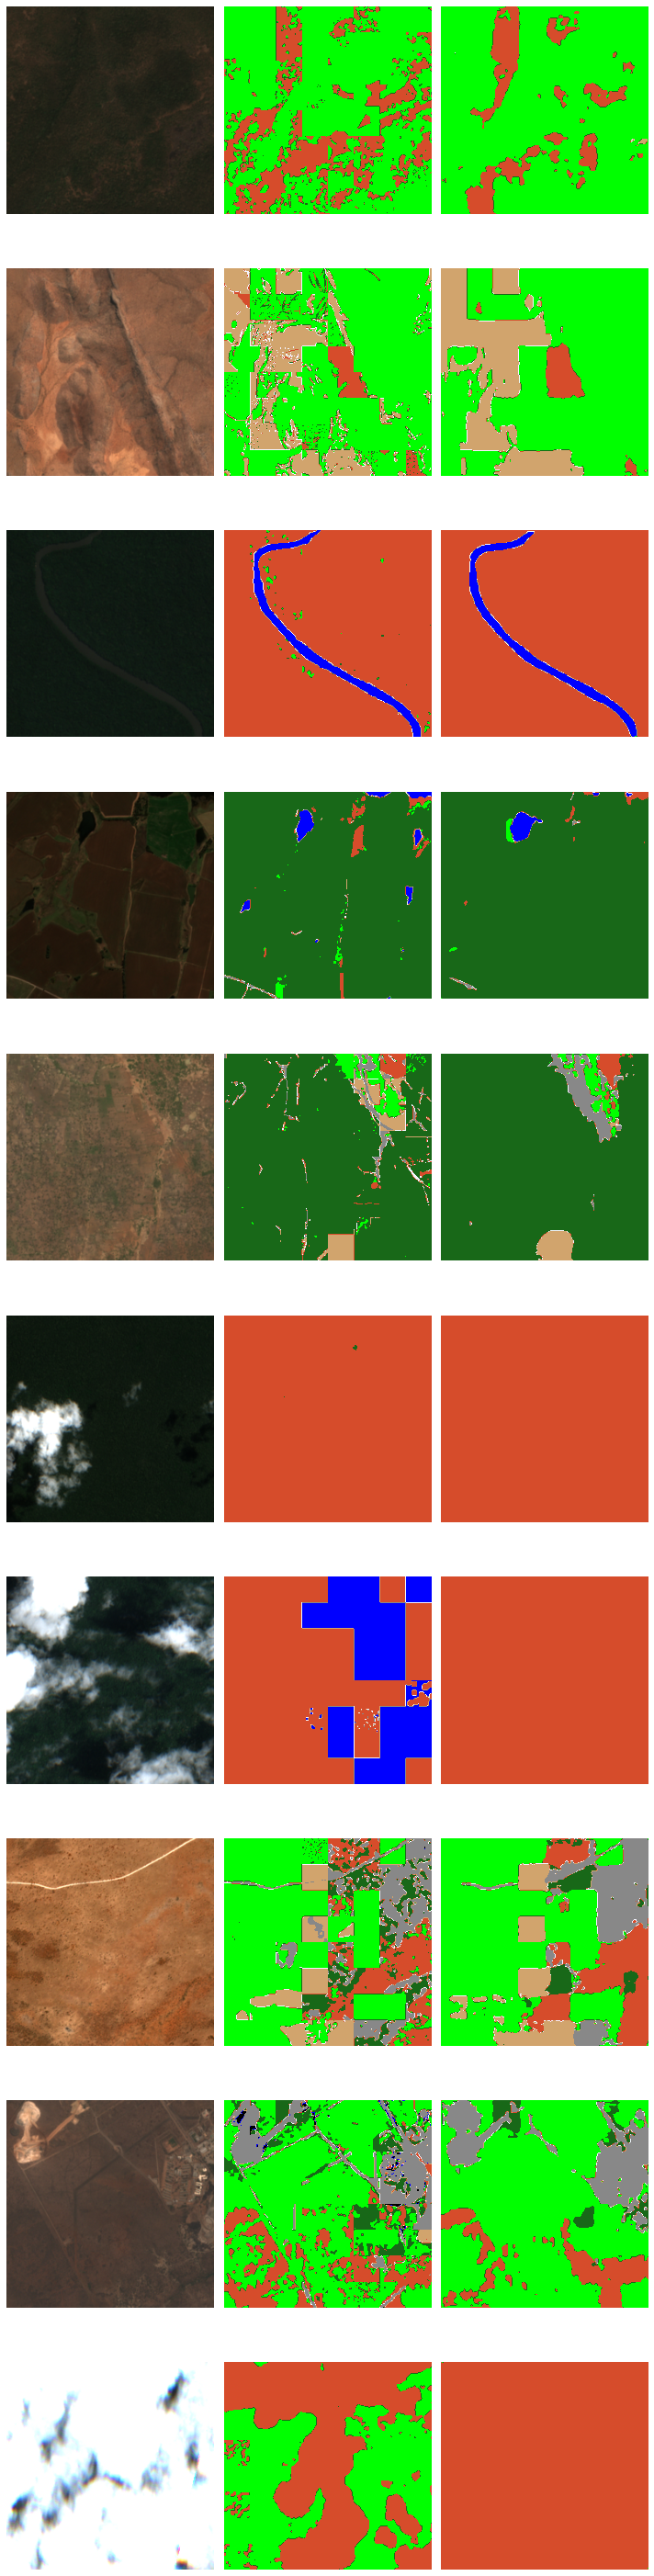

In [21]:
imgs, masks = next(iter(dl))

preds = task.predict(imgs)
preds = torch.argmax(preds, axis=1)

fig = plt.figure(figsize=(10, len(imgs)*4))
for i, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):    
    img = img.permute(1,2,0) # rgb
    ax = plt.subplot(len(imgs), 3, 3*i + 1)
    ax.imshow(img) 
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 2)
    mask = torch.argmax(mask, axis=0)
    ax.imshow(mask, cmap=cmap, norm=norm)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 3)
    ax.imshow(pred, cmap=cmap, norm=norm)
    ax.axis('off')
plt.tight_layout()
plt.show()